<h1 style="color:#872325"> Regresión Logística </h1>

### Elaboró: Jorge Alberto Morúa Amaya
### Clave: 193699
### 28/04/2020

* Agrupar por sector (limpiar los datos)
* Entrenar una regresión Logística y encontrar los mejores hiperparámetros
* Probar cross-validation
* Graficar Precision-Recall curve

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, cross_val_score,train_test_split,cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,precision_score, recall_score, f1_score,roc_curve,auc, precision_recall_curve
from statsmodels.tsa.stattools import adfuller
from sklearn.pipeline import Pipeline
from sklearn import preprocessing

In [2]:
#cargamos el archivo con la informacion de los indices
ipc_path = "../notebooks/ipc.xlsx" # Modificar a ruta
market = pd.read_excel(ipc_path, index_col=0)
market.columns = [c.replace(" MF Equity", "").replace(" INDEX", "").replace("*", "") for c in market.columns]
market.head()

,KIMBERA,GAPB,CEMEXCPO,ASURB,GFNORTEO,KOFUBL,AC,LABB,FEMSAUBD,OMAB,...,MEGACPO,GCC,BIMBOA,GMEXICOB,GCARSOA1,TLEVICPO,ALFAA,BSMXB,PINFRA,MEXBOL
DATE,,,,,,,,,,,,,,,,,,,,,
2016-01-01,40.37,152.05,8.72,243.89,94.99,123.90,104.68,13.85,161.63,83.61,...,64.19,44.81,45.95,36.79,70.98,94.34,34.10,30.25,202.73,42977.50
2016-01-04,39.16,148.57,8.43,238.29,91.79,120.29,102.09,14.41,157.62,81.77,...,64.45,43.51,45.02,35.71,69.83,92.62,33.74,29.46,202.93,42113.70
2016-01-05,38.89,147.93,8.31,233.03,91.72,118.82,101.12,13.77,157.80,81.58,...,63.16,43.51,45.77,36.45,70.70,91.89,33.99,29.72,203.56,42041.68
2016-01-06,39.13,146.99,8.29,231.97,91.63,120.32,102.50,13.65,156.37,82.03,...,63.27,43.51,45.97,35.57,70.47,90.41,33.65,29.67,199.80,41691.19
2016-01-07,39.16,141.32,7.64,230.71,89.54,120.20,101.16,13.25,155.14,80.94,...,62.78,42.76,46.18,35.01,68.15,90.23,31.46,28.50,196.75,40661.57


In [3]:
#obtenemos los indices del sector PRODUCTOS DE CONSUMO FRECUENTE
sdf_pcf = np.mean(market[['AC', 'BIMBOA', 'CUERVO', 'FEMSAUBD', 'GRUMAB', 'KOFUBL', 'WALMEX']], axis=1)
sdf_pcf.name = "CONS_FREC"

In [4]:
#obtenemos los indices del sector INDUSTRIAL
sdf_ind = np.mean(market[['ALFAA', 'RA', 'ASURB', 'GAPB', 'GCARSOA1', 'OMAB', 'ORBIA', 'PINFRA']], axis=1)
sdf_ind.name = "INDUSTRIAL"

In [5]:
df_mkt = pd.merge(sdf_pcf,sdf_ind, on="DATE")

In [6]:
#obtenemos los indices del sector MATERIALES
sdf_mat = np.mean(market[['ALPEKA', 'CEMEXCPO', 'GCC', 'GMEXICOB', 'PE&OLES']], axis=1)
sdf_mat.name = "MATERIALES"

In [7]:
df_mkt = pd.merge(df_mkt,sdf_mat, on="DATE")

In [8]:
#obtenemos los indices del sector SERVICIOS Y BIENES DE CONSUMO NO BASICO
sdf_byc = np.mean(market[['ALSEA', 'ELEKTRA', 'LIVEPOLC']], axis=1)
sdf_byc.name = "SERV_BYC"

In [9]:
df_mkt = pd.merge(df_mkt,sdf_byc, on="DATE")

In [10]:
#obtenemos los indices del sector SERVICIOS DE TELECOMUNICACIONES
sdf_tel = np.mean(market[['AMXL', 'MEGACPO', 'TLEVICPO']], axis=1)
sdf_tel.name = "TELCO"

In [11]:
df_mkt = pd.merge(df_mkt,sdf_tel, on="DATE")

In [12]:
#obtenemos los indices del sector SERVICIOS FINANCIEROS
sdf_fin = np.mean(market[['BBAJIOO', 'BOLSAA', 'BSMXB', 'GENTERA', 'GFINBURO', 'GFNORTEO']], axis=1)
sdf_fin.name = "FINANCIEROS"

In [13]:
df_mkt = pd.merge(df_mkt,sdf_fin, on="DATE")

In [14]:
#obtenemos los indices del sectoR DE ENERGIA
sdf_ene = market[['IENOVA']]
sdf_ene.columns  = ["ENERGIA"]

In [15]:
df_mkt = pd.merge(df_mkt,sdf_ene, on="DATE")

In [16]:
#obtenemos los indices del sector  SALUD
sdf_sal = market[['LABB']]
sdf_sal.columns = ["SALUD"]

In [17]:
df_mkt = pd.merge(df_mkt,sdf_sal, on="DATE")

In [18]:
sdf_mex = market[["MEXBOL"]]
df_mkt = pd.merge(df_mkt,sdf_mex, on="DATE")

In [19]:
df_mkt

,CONS_FREC,INDUSTRIAL,MATERIALES,SERV_BYC,TELCO,FINANCIEROS,ENERGIA,SALUD,MEXBOL
DATE,,,,,,,,,
2016-01-01,120.233333,114.15750,58.346,216.333333,56.883333,42.510000,72.34,13.85,42977.50
2016-01-04,117.381667,112.75250,57.482,212.393333,56.366667,41.114000,72.98,14.41,42113.70
2016-01-05,116.545000,112.06000,57.648,209.043333,55.673333,41.154000,71.48,13.77,42041.68
2016-01-06,118.486667,111.13125,56.514,202.943333,55.140000,40.972000,70.94,13.65,41691.19
2016-01-07,117.721667,108.81625,56.122,200.226667,54.783333,39.818000,72.31,13.25,40661.57
...,...,...,...,...,...,...,...,...,...
2019-12-30,102.341429,143.34125,76.360,512.143333,45.550000,41.023333,86.96,18.58,43657.48
2019-12-31,101.628571,143.25625,75.780,510.700000,45.636667,41.191667,88.93,18.71,43541.02
2020-01-01,101.628571,143.25625,75.780,510.700000,45.636667,41.191667,88.93,18.71,43541.02


In [20]:
window = 20
market_t = df_mkt.copy()
rolling_mean = market_t.rolling(window).mean()
rolling_std =  market_t.rolling(window).std()
market_t = (market_t - rolling_mean) / rolling_std
market_t = market_t.dropna()

In [21]:
y = (market_t["MEXBOL"].diff().shift(-1) > 0) * 1.0
X = market_t.drop("MEXBOL", axis=1).join(y, how="inner")

y = X["MEXBOL"]
X = X.drop("MEXBOL", axis=1)

In [22]:
train_period = "2019-10"
test_period = "2019-11-20"
Xtrain, ytrain = X[:train_period], y[:train_period]
Xtest, ytest = X[:test_period], y[:test_period]

In [108]:
#Hiperparametros
pipe= Pipeline([
    ('scale', preprocessing.StandardScaler()),
    ('clf', LogisticRegression(max_iter=120))
])


param_grid = [
    {
        #'clf__penalty' : ['l1', 'l2'],
    #'clf__C' : np.logspace(-4, 4, 20),
     'clf__C': np.logspace(-5, 5, 30),
    #'clf__solver' : ['liblinear']
     'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']   
    }
]

In [127]:
#Grid_serch
#clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
grid = GridSearchCV(pipe, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

In [128]:
best_model = grid.fit(Xtrain, ytrain)

Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:    1.7s finished


In [129]:
print('Los mejores parametros encontrados son:')
print(best_model.best_params_)

Los mejores parametros encontrados son:
{'clf__C': 0.002592943797404667, 'clf__solver': 'liblinear'}


In [130]:
y_pred = best_model.predict(Xtest.values)

In [131]:
print('Confusion matrix')
print(pd.DataFrame(confusion_matrix(ytest, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))

Confusion matrix
     pred_neg  pred_pos
neg       319       183
pos       224       269


In [132]:
precision_score(ytest, y_pred)

0.5951327433628318

In [133]:
y_scores = best_model.predict_proba(Xtest)[:, 1]

In [134]:
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

In [135]:
fpr, tpr, auc_thresholds = roc_curve(ytest, y_scores)
print('ROC VALUE:')
print(auc(fpr, tpr)) # AUC of ROC

ROC VALUE:
0.6402422763307825


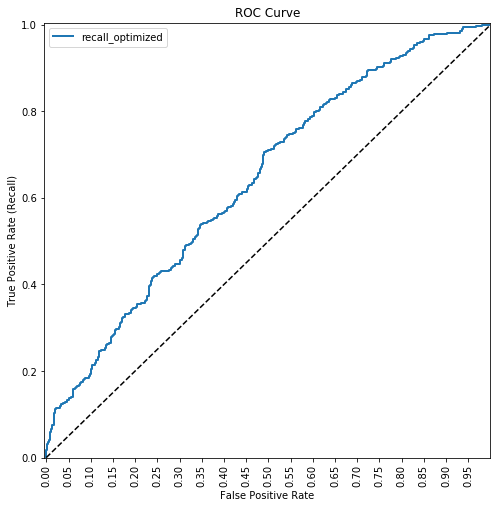

In [136]:
plot_roc_curve(fpr, tpr, 'recall_optimized')

In [137]:
p, r, thresholds = precision_recall_curve(ytest, y_scores)

In [138]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(ytest, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)

     pred_neg  pred_pos
neg         2       500
pos         0       493


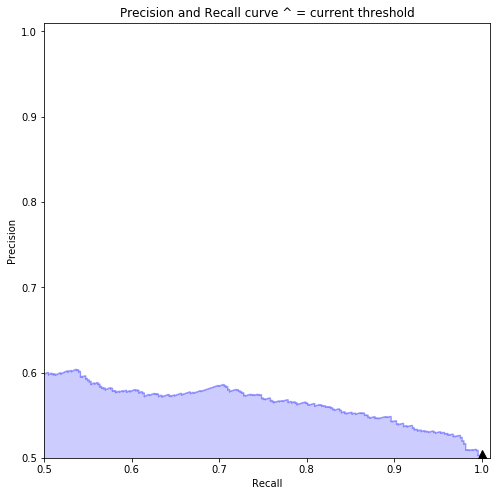

In [139]:
precision_recall_threshold(p, r, thresholds, 0.30)